In [23]:
import numpy as np
import pandas as pd
from scipy import stats

import dowhy
from dowhy import CausalModel

In [36]:
class GPSMemorySCM:

    def __init__(self, random_seed=None):
        self.random_seed = random_seed
        self.u_x = stats.truncnorm(0, np.inf, scale=5)
        self.u_y = stats.norm(scale=2)
        self.u_z1 = stats.norm(scale=2)
        self.u_z2 = stats.norm(scale=2)
        self.u = stats.truncnorm(0, np.inf, scale=4)

    def sample(self, sample_size=100, treatment_value=None):
        """Samples from the SCM"""
        if self.random_seed:
            np.random.seed(self.random_seed)

        u_x = self.u_x.rvs(sample_size)
        u_y = self.u_y.rvs(sample_size)
        u_z1 = self.u_z1.rvs(sample_size)
        u_z2 = self.u_z2.rvs(sample_size)
        u = self.u.rvs(sample_size)

        if treatment_value:
            gps = np.array([treatment_value] * sample_size)
        else:
            gps = u_x + 0.7 * u

        hippocampus = -0.2 * gps + 0.35 * u_z1
        sensoring = 0.25 * u_z2 - 0.2 * hippocampus
        memory = 0.45 * u + 0.25 * sensoring

        return gps, hippocampus, sensoring, memory

    def intervene(self, treatment_value, sample_size=100):
        """Intervenes on the SCM"""
        return self.sample(treatment_value=treatment_value, sample_size=sample_size)

In [37]:
# Instantiate the SCM
scm = GPSMemorySCM()

# Generate observational data
gps_obs, hippocampus_obs, sensoring_obs, memory_obs = scm.sample(1000)

# Encode as a pandas df
df = pd.DataFrame(
    np.vstack([gps_obs, hippocampus_obs, sensoring_obs, memory_obs]).T, columns=["X", "Z", "W", "Y"]
)

In [38]:
df

,X,Z,W,Y
0,5.899745,-0.467022,-1.359655,0.031358
1,5.277099,-1.088163,0.576982,2.240177
2,10.317788,-2.075394,-0.119706,3.844564
3,9.428606,-1.746431,-0.367805,2.389196
4,11.670525,-2.505667,0.279744,2.332453
...,...,...,...,...
995,11.512150,-2.538028,0.644965,1.952960
996,3.825967,-0.793832,0.136650,1.512556
997,3.768008,0.374120,-0.214379,1.361875
998,4.499537,-0.923700,0.326937,2.238676


In [39]:
gml_graph = """
graph [
    directed 1
    
    node [
        id "X" 
        label "X"
    ]    
    node [
        id "Z"
        label "Z"
    ]
    node [
        id "Y"
        label "Y"
    ]
    node [
        id "U"
        label "U"
    ]
    node [
        id "W"
        label "W"
    ]
    
    edge [
        source "X"
        target "Z"
    ]
    edge [
        source "Z"
        target "W"
    ]
    edge [
        source "W"
        target "Y"
    ]
    edge [
        source "U"
        target "Z"
    ]
    edge [
        source "U"
        target "W"
    ]
    edge [
        source "U"
        target "Y"
    ]
]
"""

In [40]:
model = CausalModel(data=df, treatment="X", outcome="Y", graph=gml_graph)

/Users/vicentelavagnino/Desktop/IIC2433-GH/venv_umap/lib/python3.11/site-packages/dowhy/causal_model.py:583: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


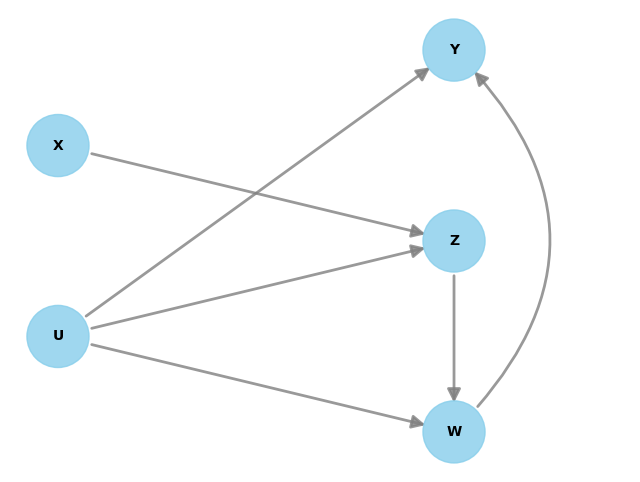

In [41]:
model.view_model()

In [42]:
estimand = model.identify_effect()
print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d        
────(E[Y])
d[X]      
Estimand assumption 1, Unconfoundedness: If U→{X} and U→Y then P(Y|X,,U) = P(Y|X,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

